In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/ML_Seizure_Project"

DL_Pipeline  HilbertOutput  InputImageForStacking  RawData


In [ ]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

class ContinuousWaveletTransform(object):
    def __init__(self, n_scales, border_crop=0, stride=1, name="cwt"):
        self.n_scales = n_scales
        self.border_crop = border_crop
        self.stride = stride
        self.name = name
        with tf.compat.v1.variable_scope(self.name):
            self.real_part, self.imaginary_part = self._build_wavelet_bank()

    def _build_wavelet_bank(self):
        real_part = None
        imaginary_part = None
        return real_part, imaginary_part

    def __call__(self, inputs):

        border_crop = int(self.border_crop / self.stride)
        start = border_crop
        end = (-border_crop) if (border_crop > 0) else None
        with tf.compat.v1.variable_scope(self.name):

            inputs_unstacked = tf.unstack(inputs, axis=2)
            multi_channel_cwt = []
            for j, single_channel in enumerate(inputs_unstacked):
                inputs_expand = tf.expand_dims(single_channel, axis=1)
                inputs_expand = tf.expand_dims(inputs_expand, axis=3)
                with tf.name_scope('%s_%d' % (self.name, j)):
                    bank_real = self.real_part
                    bank_imag = -self.imaginary_part
                    out_real = tf.nn.conv2d(
                        input=inputs_expand, filters=bank_real,
                        strides=[1, 1, self.stride, 1], padding="SAME")
                    out_imag = tf.nn.conv2d(
                        input=inputs_expand, filters=bank_imag,
                        strides=[1, 1, self.stride, 1], padding="SAME")
                    out_real_crop = out_real[:, :, start:end, :]
                    out_imag_crop = out_imag[:, :, start:end, :]
                    out_concat = tf.concat(
                        [out_real_crop, out_imag_crop], axis=1)
                    single_scalogram = tf.transpose(
                        out_concat, perm=[0, 2, 3, 1])
                    multi_channel_cwt.append(single_scalogram)
            scalograms = tf.concat(multi_channel_cwt, -1)
        return scalograms

In [ ]:
class ComplexMorletCWT(ContinuousWaveletTransform):
    def __init__(
            self,
            wavelet_width,
            fs,
            lower_freq,
            upper_freq,
            n_scales,
            size_factor=1.0,
            trainable=False,
            border_crop=0,
            stride=1,
            name="cwt"):

        if lower_freq > upper_freq:
            raise ValueError("lower_freq should be lower than upper_freq")
        if lower_freq < 0:
            raise ValueError("Expected positive lower_freq.")

        self.initial_wavelet_width = wavelet_width
        self.fs = fs
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.size_factor = size_factor
        self.trainable = trainable
        s_0 = 1 / self.upper_freq
        s_n = 1 / self.lower_freq
        base = np.power(s_n / s_0, 1 / (n_scales - 1))
        self.scales = s_0 * np.power(base, np.arange(n_scales))
        self.frequencies = 1 / self.scales
        self.wavelet_width = tf.Variable(
            initial_value=self.initial_wavelet_width,
            trainable=self.trainable,
            name='wavelet_width',
            dtype=tf.float32)
        super().__init__(n_scales, border_crop, stride, name)

    def _build_wavelet_bank(self):
        with  tf.compat.v1.variable_scope("cmorlet_bank"):

            truncation_size = self.scales.max() * np.sqrt(4.5 * self.initial_wavelet_width) * self.fs
            one_side = int(self.size_factor * truncation_size)
            kernel_size = 2 * one_side + 1
            k_array = np.arange(kernel_size, dtype=np.float32) - one_side
            t_array = k_array / self.fs
            wavelet_bank_real = []
            wavelet_bank_imag = []
            for scale in self.scales:
                norm_constant = tf.sqrt(np.pi * self.wavelet_width) * scale * self.fs / 2.0
                scaled_t = t_array / scale
                exp_term = tf.exp(-(scaled_t ** 2) / self.wavelet_width)
                kernel_base = exp_term / norm_constant
                kernel_real = kernel_base * np.cos(2 * np.pi * scaled_t)
                kernel_imag = kernel_base * np.sin(2 * np.pi * scaled_t)
                wavelet_bank_real.append(kernel_real)
                wavelet_bank_imag.append(kernel_imag)
            wavelet_bank_real = tf.stack(wavelet_bank_real, axis=-1)
            wavelet_bank_imag = tf.stack(wavelet_bank_imag, axis=-1)

            wavelet_bank_real = tf.expand_dims(wavelet_bank_real, axis=0)
            wavelet_bank_imag = tf.expand_dims(wavelet_bank_imag, axis=0)
            wavelet_bank_real = tf.expand_dims(wavelet_bank_real, axis=2)
            wavelet_bank_imag = tf.expand_dims(wavelet_bank_imag, axis=2)
        return wavelet_bank_real, wavelet_bank_imag

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/My Drive/ML_Seizure_Project/HilbertOutput/p034seizure/sub_2.csv",skiprows=1, header=None, delimiter='\t')
df = df.apply(pd.to_numeric, errors='coerce')
fs=200

demo_signal = df.values.astype(float)

n_samples_per_channel = demo_signal.shape[0]
time_axis = np.arange(0, n_samples_per_channel) / fs

In [ ]:
lower_freq = 1
upper_freq = 30
n_scales = 32
wavelet_width = 1

tf.compat.v1.reset_default_graph()

tf.compat.v1.disable_eager_execution()

cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales)

print(cwt.frequencies)

[30.         26.88265645 24.0892406  21.58609264 19.34305042 17.33308597
 15.53197985 13.91802927 12.47178665 11.17582519 10.01452897  8.97390473
  8.04141326  7.20581834  6.45705129  5.78608972  5.18484874  4.64608358
  4.16330229  3.73068751  3.34302635  2.99564763  2.68436554  2.40542922
  2.15547758  1.93149877  1.73079393  1.55094462  1.38978371  1.24536927
  1.11596114  1.        ]


In [ ]:
which_scale = -1

real_bank = cwt.real_part
imag_bank = cwt.imaginary_part
single_real_wavelet = real_bank[0, :, 0, which_scale]
single_imag_wavelet = imag_bank[0, :, 0, which_scale]

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    np_single_real_wavelet, np_single_imag_wavelet = sess.run([single_real_wavelet, single_imag_wavelet])

single_wavelet_size = np_single_real_wavelet.size
time_axis = np.arange(0, single_wavelet_size) / fs
time_axis = time_axis - np.mean(time_axis)

# plt.figure(figsize=(10,4), dpi=80)
# plt.plot(time_axis, np_single_real_wavelet, label="Real part")
# plt.plot(time_axis, np_single_imag_wavelet, label="Imaginary part")
# plt.title("Complex Morlet Wavelet for %1.2f Hz (%d samples)" % (cwt.frequencies[which_scale], single_wavelet_size))
# plt.legend()
# plt.xlabel("Time [s]")

In [ ]:
prepared_signal = demo_signal.reshape((1, -1, 1)).astype(np.float32)
scalogram = cwt(prepared_signal)

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    np_scalogram = sess.run(scalogram)
# print("The result has shape", np_scalogram.shape)

In [ ]:
scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

# fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
# axes[0].plot(demo_signal, linewidth=0.8)
# axes[0].set_title("Demo signal")
# axes[1].imshow(scalogram_real.T, interpolation="none", aspect="auto", extent=[0, scalogram_real.shape[0], 0, 1])
# axes[1].set_title("Real part of scalogram")
# axes[1].set_yticks(chosen_freq_pos)
# axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
# axes[2].imshow(scalogram_imag.T, interpolation="none", aspect="auto", extent=[0, scalogram_imag.shape[0], 0, 1])
# axes[2].set_title("Imaginary part of scalogram")
# axes[2].set_yticks(chosen_freq_pos)
# axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
# axes[3].imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
# axes[3].set_title("Magnitude of scalogram")
# axes[3].set_yticks(chosen_freq_pos)
# axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
# axes[3].set_xlabel("Time [samples]")
# plt.tight_layout()

In [ ]:
tf.compat.v1.reset_default_graph()
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=424)
scalogram = cwt(prepared_signal)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    np_scalogram = sess.run(scalogram)
print("The result has shape", np_scalogram.shape)

scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

# fig, ax = plt.subplots(1, 1, figsize=(2, 1.8), dpi=80)
# ax.imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
# ax.set_yticks(chosen_freq_pos)
# ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
# ax.set_title("Magnitude of scalogram")
# ax.set_xlabel("Time [samples]")

The result has shape (1, 920752, 32, 2)


In [ ]:
wavelet_width_list = [1.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    tf.compat.v1.reset_default_graph()
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    scalogram = cwt(prepared_signal)
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        np_scalogram = sess.run(scalogram)
    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]



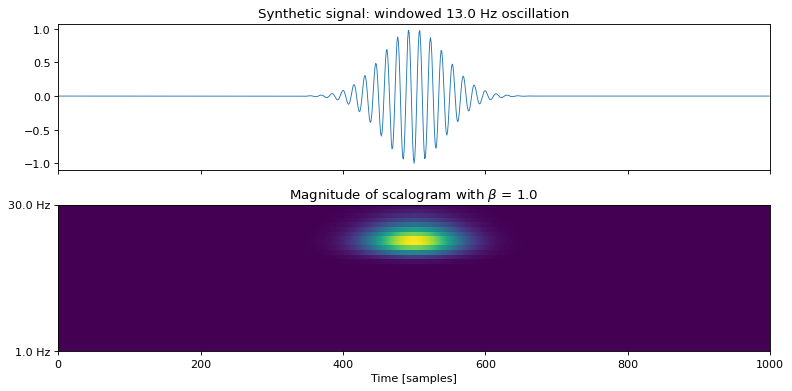

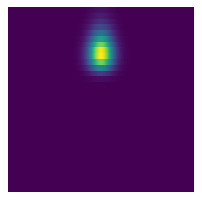

In [ ]:
n_samples = 1000
central_freq = 13
time_axis = np.arange(n_samples) / fs
oscill = np.cos(2 * np.pi * central_freq * time_axis)
window = np.exp(- (time_axis - np.mean(time_axis)) ** 2 / 0.1)
synt_signal = oscill * window

prepared_synt_signal = synt_signal.reshape((1, -1, 1)).astype(np.float32)

wavelet_width_list = [1.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    tf.compat.v1.reset_default_graph()
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    scalogram = cwt(prepared_synt_signal)
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        np_scalogram = sess.run(scalogram)
    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=80, sharex=True)
axes[0].plot(synt_signal, linewidth=0.8)
axes[0].set_title("Synthetic signal: windowed %1.1f Hz oscillation" % central_freq)


axes[1].imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto",
    extent=[0, scalograms_list[0].shape[0], 0, 1])
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[1].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[0])
axes[1].set_xlabel("Time [samples]")
plt.tight_layout()

plt.figure(figsize=(3,3), dpi=80)
plt.imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto",
    extent=[0, scalograms_list[0].shape[0], 0, 1])
plt.axis('off')
plt.savefig("img34_3.png", bbox_inches='tight', pad_inches=0)